In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(".")))
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pepland.model.core import PepLandFeatureExtractor
from chemberta.inference import PepPM

from omegaconf import OmegaConf
import torch

import pandas as pd
from collections import Counter

from rdkit import Chem
from tqdm import tqdm

import pickle

# use t-SNE to reduce the dimension of the features and draw scatter plots with labels as hue
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/home/richard/miniconda3/envs/latent_space/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda:0")

root_dir = os.path.dirname(".")
cfg = OmegaConf.load(os.path.join(root_dir, "./configs/inference.yaml"))
pooling = cfg.inference.pool
model_path = os.path.join(root_dir, cfg.inference.model_path)
data_path = os.path.join(root_dir, cfg.inference.data)


In [ ]:
pepland_model = PepLandFeatureExtractor(model_path, pooling)
pepland_model.to(device)

In [7]:
chemberta_model = PepPM(
    model_path="/mnt/share/pretrained_models/ChemBERTa-77M-MTR",
    tokenizer_path="/mnt/share/pretrained_models/ChemBERTa-77M-MTR",
    max_length=512,
    freeze_layers=0)
chemberta_model.to("cuda:1")

Some weights of RobertaModel were not initialized from the model checkpoint at /mnt/share/pretrained_models/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pre-trained sequence model with success.


PepPM(
  (seq_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNo

In [9]:
def check_smiles_valid(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def clean_dataset(all_seqs, all_labels, seq_type):
    # if seq is amino acid sequence, transform to smiles
    # if seq is smiles, check whether it is valid smiles
    # if not valid, remove it
    # return seqs, labels
    all_seqs_clean = []
    all_labels_clean = []
    for seq, label in tqdm(zip(all_seqs, all_labels), total=len(all_seqs)):
        
        if seq_type == "seq":
            try:
                smiles = Chem.MolToSmiles(Chem.MolFromSequence(seq))
                if smiles:
                    all_seqs_clean.append(smiles)
                    all_labels_clean.append(label)
                else:
                    print(f"Invalid seq: {seq}")
            except Exception as e:
                print(f"Error transforming seq to smiles: {e}")
    
        elif seq_type == "smiles":
            try:
                if check_smiles_valid(seq):
                    all_seqs_clean.append(seq)
                    all_labels_clean.append(label)
                else:
                    print(f"Invalid smiles: {seq}")
            except Exception as e:
                print(f"Error checking smiles: {e}")
        else:
            raise ValueError(f"Invalid seq_type: {seq_type}")   

    return all_seqs_clean, all_labels_clean


In [10]:
## ---- c-CPP ----
all_cpp_seqs = []
all_cpp_labels = []
with open("./data/eval/c-CPP.txt", "r") as f:
    lines = f.readlines()
    for line in tqdm(lines, total=len(lines)):
        seq, label = line.split(",")
        seq = seq.strip()
        label = int(label.strip())
        if seq:
            all_cpp_seqs.append(seq)
            all_cpp_labels.append(label)

## ---- nc-CPP ----

nc_cpp_df = pd.read_csv("./data/eval/nc-CPP.csv")
nc_cpp_seqs = nc_cpp_df["SMILES"].tolist()
nc_cpp_labels = nc_cpp_df["Permeability"].tolist()

## ------ c-Binding ----
c_binding_df = pd.read_csv("./data/eval/c-binding.csv", index_col=0)
c_binding_seqs = c_binding_df["Merge_SMILES"].tolist()
c_binding_aa = c_binding_df["seq2"].tolist()
c_binding_labels = c_binding_df["affinity"].tolist()

## ---- nc-Binding ----
nc_binding_df = pd.read_csv("./data/eval/nc-binding.csv", index_col=0)
nc_binding_seqs = nc_binding_df["Merge_SMILES"].tolist()
nc_binding_labels = nc_binding_df["affinity"].tolist()

## ---- solubility ----
all_sol_seqs = []
all_sol_labels = []
with open("./data/eval/c-Sol.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        seq, label = line.split(",")
        seq = seq.strip()
        label = int(label.strip())
        if seq:
            all_sol_seqs.append(seq)
            all_sol_labels.append(label)

all_cpp_seqs, all_cpp_labels = clean_dataset(all_cpp_seqs, all_cpp_labels, "seq")
nc_cpp_seqs, nc_cpp_labels = clean_dataset(nc_cpp_seqs, nc_cpp_labels, "smiles")
c_binding_seqs, c_binding_labels = clean_dataset(c_binding_seqs, c_binding_labels, "smiles")
nc_binding_seqs, nc_binding_labels = clean_dataset(nc_binding_seqs, nc_binding_labels, "smiles")
all_sol_seqs, all_sol_labels = clean_dataset(all_sol_seqs, all_sol_labels, "seq")


100%|██████████| 2324/2324 [00:00<00:00, 737390.31it/s]
/tmp/ipykernel_31643/2313457973.py:16: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  nc_cpp_df = pd.read_csv("./data/eval/nc-CPP.csv")
  9%|▉         | 164/1806 [00:00<00:02, 812.77it/s]

Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float


 17%|█▋        | 312/1806 [00:00<00:02, 618.39it/s]

Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float


100%|██████████| 304/304 [00:00<00:00, 2975.95it/s]


Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from thi

100%|██████████| 1511/1511 [00:09<00:00, 167.17it/s]


In [ ]:
# feature extraction for all datasets
pepland_embeds = {}
batch_size = 128
for dataset_name, seqs, labels in [
    ("cpp", all_cpp_seqs, all_cpp_labels),
    ("nc_cpp", nc_cpp_seqs, nc_cpp_labels),
    ("c_binding", c_binding_seqs, c_binding_labels),
    ("nc_binding", nc_binding_seqs, nc_binding_labels),
    ("sol", all_sol_seqs, all_sol_labels)
]:
    tmp_embeds = []

    with torch.no_grad():
        for batch_idx in tqdm(range(0, len(seqs), batch_size),
                              total=len(seqs) // batch_size):
            batch_seqs = seqs[batch_idx:batch_idx + batch_size]
            embeds = pepland_model(batch_seqs)
            tmp_embeds.append(embeds)

    pepland_embeds[dataset_name] = torch.cat(tmp_embeds, dim=0)

In [29]:
chemberta_embeds = {}
for dataset_name, seqs, labels in [
    ("cpp", all_cpp_seqs, all_cpp_labels),
    ("nc_cpp", nc_cpp_seqs, nc_cpp_labels),
    ("c_binding", c_binding_seqs, c_binding_labels),
    ("nc_binding", nc_binding_seqs, nc_binding_labels),
    ("sol", all_sol_seqs, all_sol_labels)
]:
    chemberta_embeds[dataset_name] = chemberta_model.feature_extract(
        seqs, batch_size=batch_size, pool="max")

Extracting features from sequence model: 19it [00:03,  4.90it/s]                        
Extracting features from sequence model: 58it [00:03, 16.23it/s]                        
Extracting features from sequence model: 15it [00:01,  8.10it/s]                        
Extracting features from sequence model: 3it [00:00,  8.70it/s]                       
Extracting features from sequence model: 12it [00:02,  4.49it/s]                        


In [6]:
if os.path.exists(
        f"./data/eval/pepland_{pooling}_embeds.pkl") and os.path.exists(
            f"./data/eval/chemberta_{pooling}_embeds.pkl") and os.path.exists(
                f"./data/eval/pepland_{pooling}_tsne_embeds.pkl"
            ) and os.path.exists(
                f"./data/eval/chemberta_{pooling}_tsne_embeds.pkl"):
    # read the embeddings
    with open(f"./data/eval/pepland_{pooling}_embeds.pkl", "rb") as f:
        pepland_embeds = pickle.load(f)
    with open(f"./data/eval/chemberta_{pooling}_embeds.pkl", "rb") as f:
        chemberta_embeds = pickle.load(f)
    with open(f"./data/eval/pepland_{pooling}_tsne_embeds.pkl", "rb") as f:
        pepland_tsne_embeds = pickle.load(f)
    with open(f"./data/eval/chemberta_{pooling}_tsne_embeds.pkl", "rb") as f:
        chemberta_tsne_embeds = pickle.load(f)
else:
    pepland_tsne_embeds = {}
    n_components = 2
    for dataset_name, embeds in pepland_embeds.items():
        tsne = TSNE(n_components=n_components, random_state=0)
        pepland_tsne_embeds[dataset_name] = tsne.fit_transform(
            embeds.cpu().numpy())

    chemberta_tsne_embeds = {}
    for dataset_name, embeds in chemberta_embeds.items():
        tsne = TSNE(n_components=n_components, random_state=0)
        chemberta_tsne_embeds[dataset_name] = tsne.fit_transform(
            embeds.cpu().numpy())

    labels_dict = {
        "cpp": all_cpp_labels,
        "nc_cpp": nc_cpp_labels,
        "c_binding": c_binding_labels,
        "nc_binding": nc_binding_labels,
        "sol": all_sol_labels
    }
    # save labels
    with open("./data/eval/labels.pkl", "wb") as f:
        pickle.dump(labels_dict, f)
    # save original embeddings and t-SNE embeddings
    with open(f"./data/eval/pepland_{pooling}_embeds.pkl", "wb") as f:
        pickle.dump(pepland_embeds, f)
    with open(f"./data/eval/pepland_{pooling}_tsne_embeds.pkl", "wb") as f:
        pickle.dump(pepland_tsne_embeds, f)
    with open(f"./data/eval/chemberta_{pooling}_embeds.pkl", "wb") as f:
        pickle.dump(chemberta_embeds, f)
    with open(f"./data/eval/chemberta_{pooling}_tsne_embeds.pkl", "wb") as f:
        pickle.dump(chemberta_tsne_embeds, f)

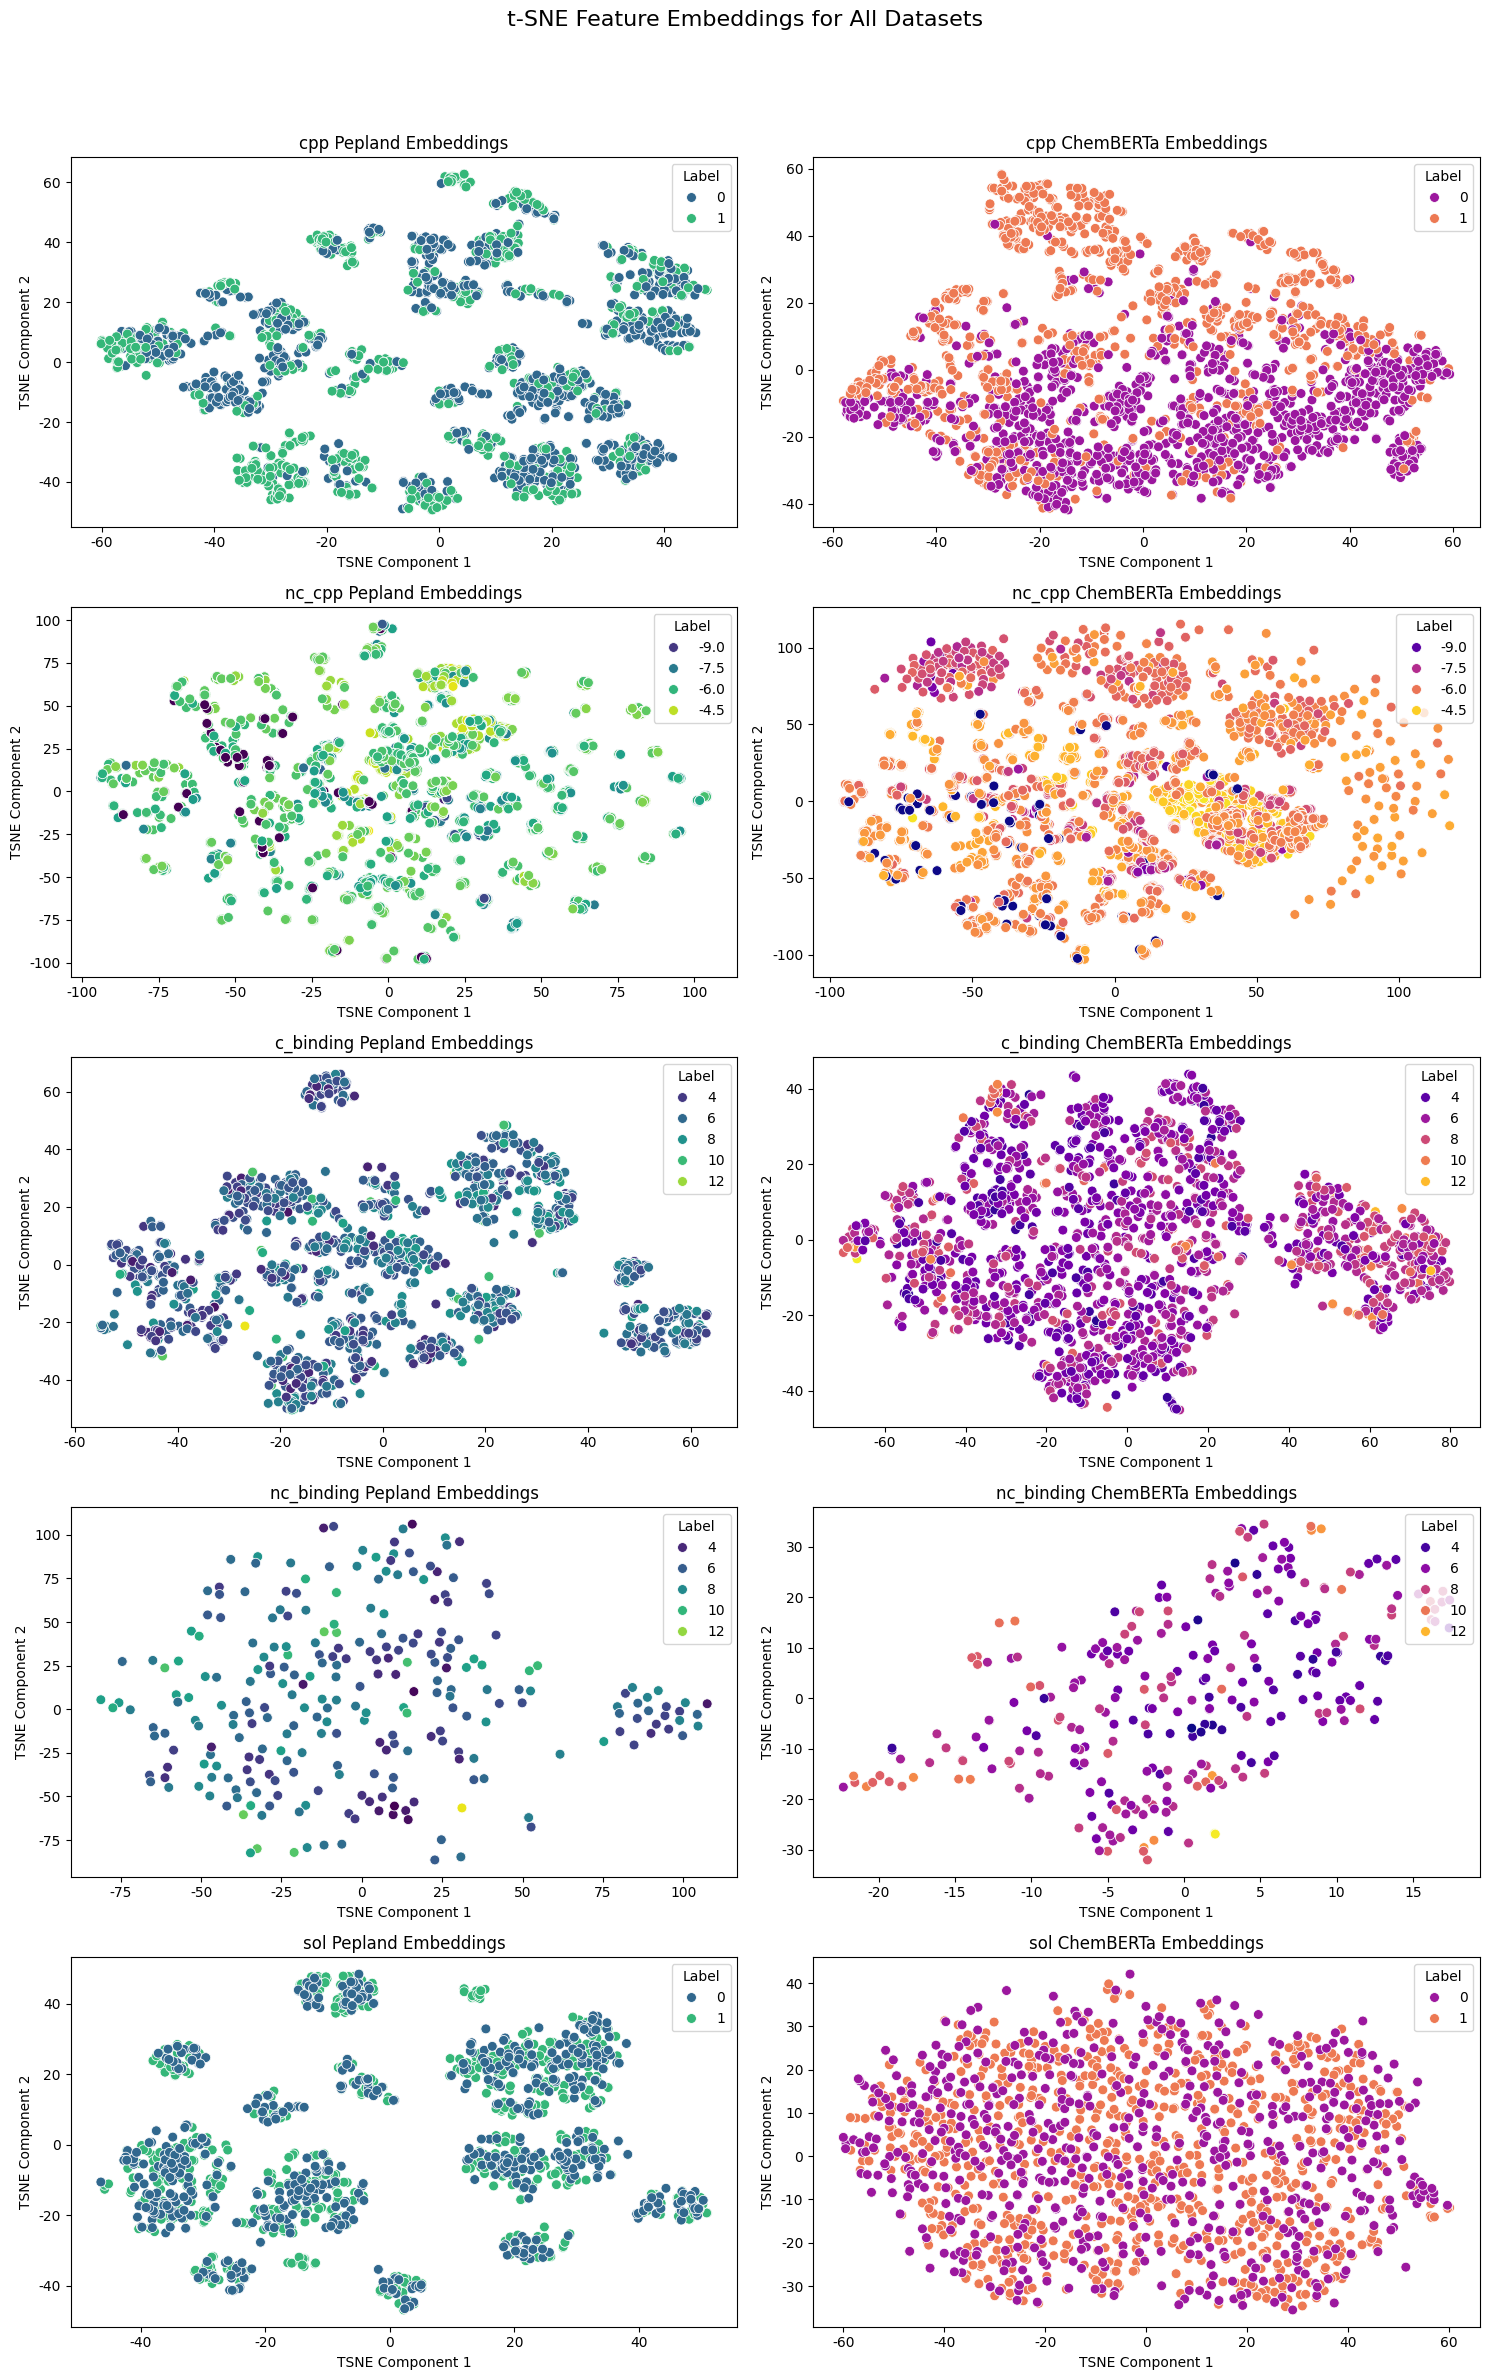

In [32]:
datasets = ["cpp", "nc_cpp", "c_binding", "nc_binding", "sol"]


# Prepare a grid for subplots
fig, axes = plt.subplots(len(datasets), 2, figsize=(15, 5 * len(datasets)), sharex=False, sharey=False)

for idx, dataset in enumerate(datasets):
    # t-SNE for pepland_tsne_embeds

    df_pepland = pd.DataFrame(pepland_tsne_embeds[dataset], columns=[f"TSNE{i+1}" for i in range(n_components)])
    df_pepland["Model"] = "Feature Pepland Embeddings"
    df_pepland["Label"] = labels_dict[dataset]
    
    # t-SNE for chemberta_embeds
    df_chemberta = pd.DataFrame(chemberta_tsne_embeds[dataset], columns=[f"TSNE{i+1}" for i in range(n_components)])
    df_chemberta["Model"] = "Feature ChemBERTa Embeddings"
    df_chemberta["Label"] = labels_dict[dataset]
    
    # Plot Feature Embeddings
    sns.scatterplot(
        data=df_pepland,
        x="TSNE1",
        y="TSNE2",
        hue="Label",
        ax=axes[idx, 0],
        palette="viridis",
        legend=True,
        s=50
    )
    axes[idx, 0].set_title(f"{dataset} Pepland Embeddings")
    axes[idx, 0].set_xlabel("TSNE Component 1")
    axes[idx, 0].set_ylabel("TSNE Component 2")


    # Plot ChemBERTa Feature Embeddings
    sns.scatterplot(
        data=df_chemberta,
        x="TSNE1",
        y="TSNE2",
        hue="Label",
        ax=axes[idx, 1],
        palette="plasma",
        legend=True,
        s=50
    )
    axes[idx, 1].set_title(f"{dataset} ChemBERTa Embeddings")
    axes[idx, 1].set_xlabel("TSNE Component 1")
    axes[idx, 1].set_ylabel("TSNE Component 2")
    # draw legend or colorbar
    axes[idx, 1].legend(title="Label", loc="upper right")

# Adjust layout and add a main title
plt.suptitle("t-SNE Feature Embeddings for All Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

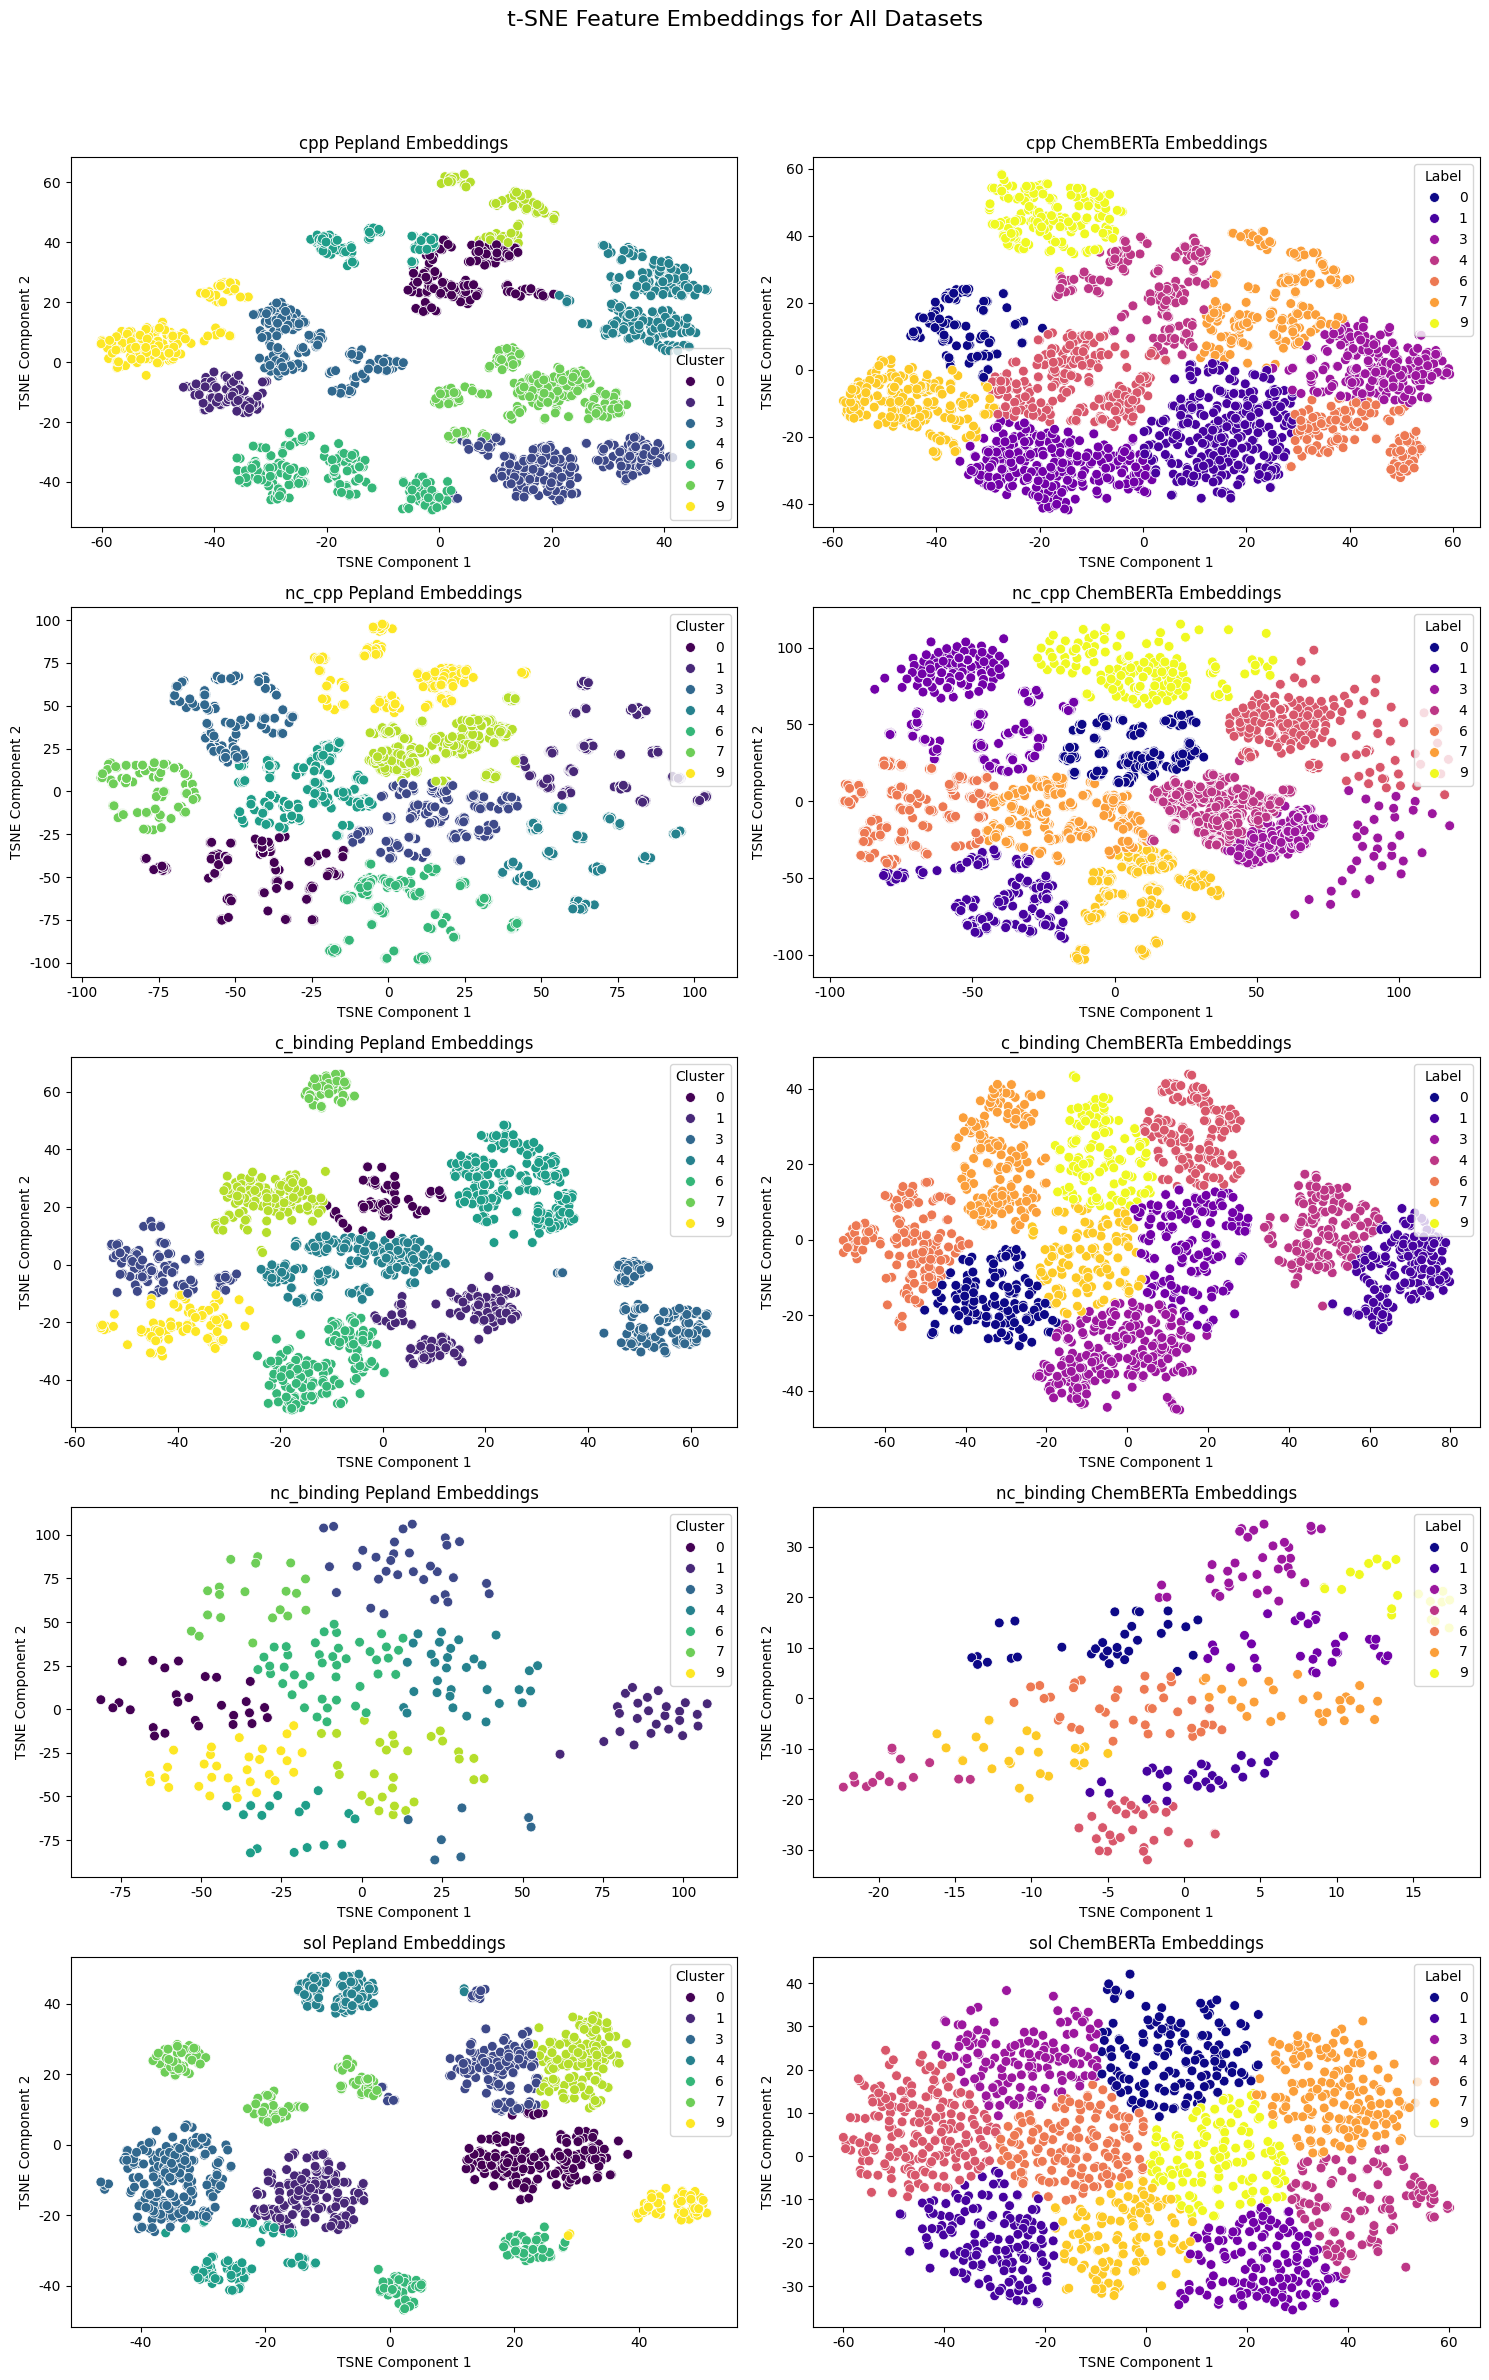

In [70]:
# use t-SNE to reduce the dimension of the features and draw scatter plots with labels as hue
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans

datasets = ["cpp", "nc_cpp", "c_binding", "nc_binding", "sol"]
cluster_model = KMeans(n_clusters=10, random_state=0)

cluster_results = {}

# Prepare a grid for subplots
fig, axes = plt.subplots(len(datasets),
                         2,
                         figsize=(15, 5 * len(datasets)),
                         sharex=False,
                         sharey=False)

for idx, dataset in enumerate(datasets):
    cluster_results[dataset] = {}
    # t-SNE for feature_embeds
    pepland_features = pepland_tsne_embeds[dataset]
    df_pepland = pd.DataFrame(
        pepland_features, columns=[f"TSNE{i+1}" for i in range(n_components)])
    df_pepland["Model"] = "Feature Pepland Embeddings"
    df_pepland["Label"] = labels_dict[dataset]
    if dataset == "cpp":
        df_pepland["SMILES"] = all_cpp_seqs
    elif dataset == "nc_cpp":
        df_pepland["SMILES"] = nc_cpp_seqs
    elif dataset == "c_binding":
        df_pepland["SMILES"] = c_binding_seqs
    elif dataset == "nc_binding":
        df_pepland["SMILES"] = nc_binding_seqs
    elif dataset == "sol":
        df_pepland["SMILES"] = all_sol_seqs

    # cluster the embeddings
    cluster_model.fit(pepland_features)
    df_pepland["Cluster"] = cluster_model.labels_
    cluster_results[dataset]["pepland"] = df_pepland.copy()

    # t-SNE for chemberta_embeds
    chemberta_features = chemberta_tsne_embeds[dataset]
    df_chemberta = pd.DataFrame(
        chemberta_features,
        columns=[f"TSNE{i+1}" for i in range(n_components)])
    df_chemberta["Model"] = "Feature ChemBERTa Embeddings"
    df_chemberta["Label"] = labels_dict[dataset]
    if dataset == "cpp":
        df_chemberta["SMILES"] = all_cpp_seqs
    elif dataset == "nc_cpp":
        df_chemberta["SMILES"] = nc_cpp_seqs
    elif dataset == "c_binding":
        df_chemberta["SMILES"] = c_binding_seqs
    elif dataset == "nc_binding":
        df_chemberta["SMILES"] = nc_binding_seqs
    elif dataset == "sol":
        df_chemberta["SMILES"] = all_sol_seqs

    # cluster the embeddings
    cluster_model.fit(chemberta_features)
    df_chemberta["Cluster"] = cluster_model.labels_
    cluster_results[dataset]["chemberta"] = df_chemberta.copy()


    # Plot Feature Embeddings
    sns.scatterplot(data=df_pepland,
                    x="TSNE1",
                    y="TSNE2",
                    hue="Cluster",
                    ax=axes[idx, 0],
                    palette="viridis",
                    legend=True,
                    s=50)
    axes[idx, 0].set_title(f"{dataset} Pepland Embeddings")
    axes[idx, 0].set_xlabel("TSNE Component 1")
    axes[idx, 0].set_ylabel("TSNE Component 2")

    # Plot ChemBERTa Feature Embeddings
    sns.scatterplot(data=df_chemberta,
                    x="TSNE1",
                    y="TSNE2",
                    hue="Cluster",
                    ax=axes[idx, 1],
                    palette="plasma",
                    legend=True,
                    s=50)
    axes[idx, 1].set_title(f"{dataset} ChemBERTa Embeddings")
    axes[idx, 1].set_xlabel("TSNE Component 1")
    axes[idx, 1].set_ylabel("TSNE Component 2")
    # draw legend or colorbar
    axes[idx, 1].legend(title="Label", loc="upper right")

# Adjust layout and add a main title
plt.suptitle("t-SNE Feature Embeddings for All Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [78]:
# Calculate the physical properties distribution for each cluster

from rdkit.Chem import Descriptors, MolFromSmiles
import pandas as pd
from typing import Optional

dataset: str = "cpp"
pep_df: pd.DataFrame = cluster_results[dataset]["pepland"]
chemberta_df: pd.DataFrame = cluster_results[dataset]["chemberta"]

# Define the properties to calculate
properties: list[str] = ["cLogP", "TPSA", "HBD", "HBA", "Weight"]

def get_mol_prop(mol: Optional[Chem.Mol], prop: str) -> Optional[float]:
    """
    Compute the specified molecular property.

    Args:
        mol (Chem.Mol): RDKit molecule object.
        prop (str): The property to compute.

    Returns:
        Optional[float]: The computed property value or None if molecule is invalid.
    """
    if mol is None:
        return None

    if prop == "cLogP":
        return Descriptors.MolLogP(mol)
    elif prop == "TPSA":
        return Descriptors.TPSA(mol)
    elif prop == "HBD":
        return Descriptors.NumHDonors(mol)
    elif prop == "HBA":
        return Descriptors.NumHAcceptors(mol)
    elif prop == "Weight":
        return Descriptors.MolWt(mol)
    else:
        raise ValueError(f"Unknown property: {prop}")

for prop in properties:
    pep_df[prop] = pep_df["SMILES"].apply(
        lambda x: get_mol_prop(MolFromSmiles(x), prop)
    )
    chemberta_df[prop] = chemberta_df["SMILES"].apply(
        lambda x: get_mol_prop(MolFromSmiles(x), prop)
    )

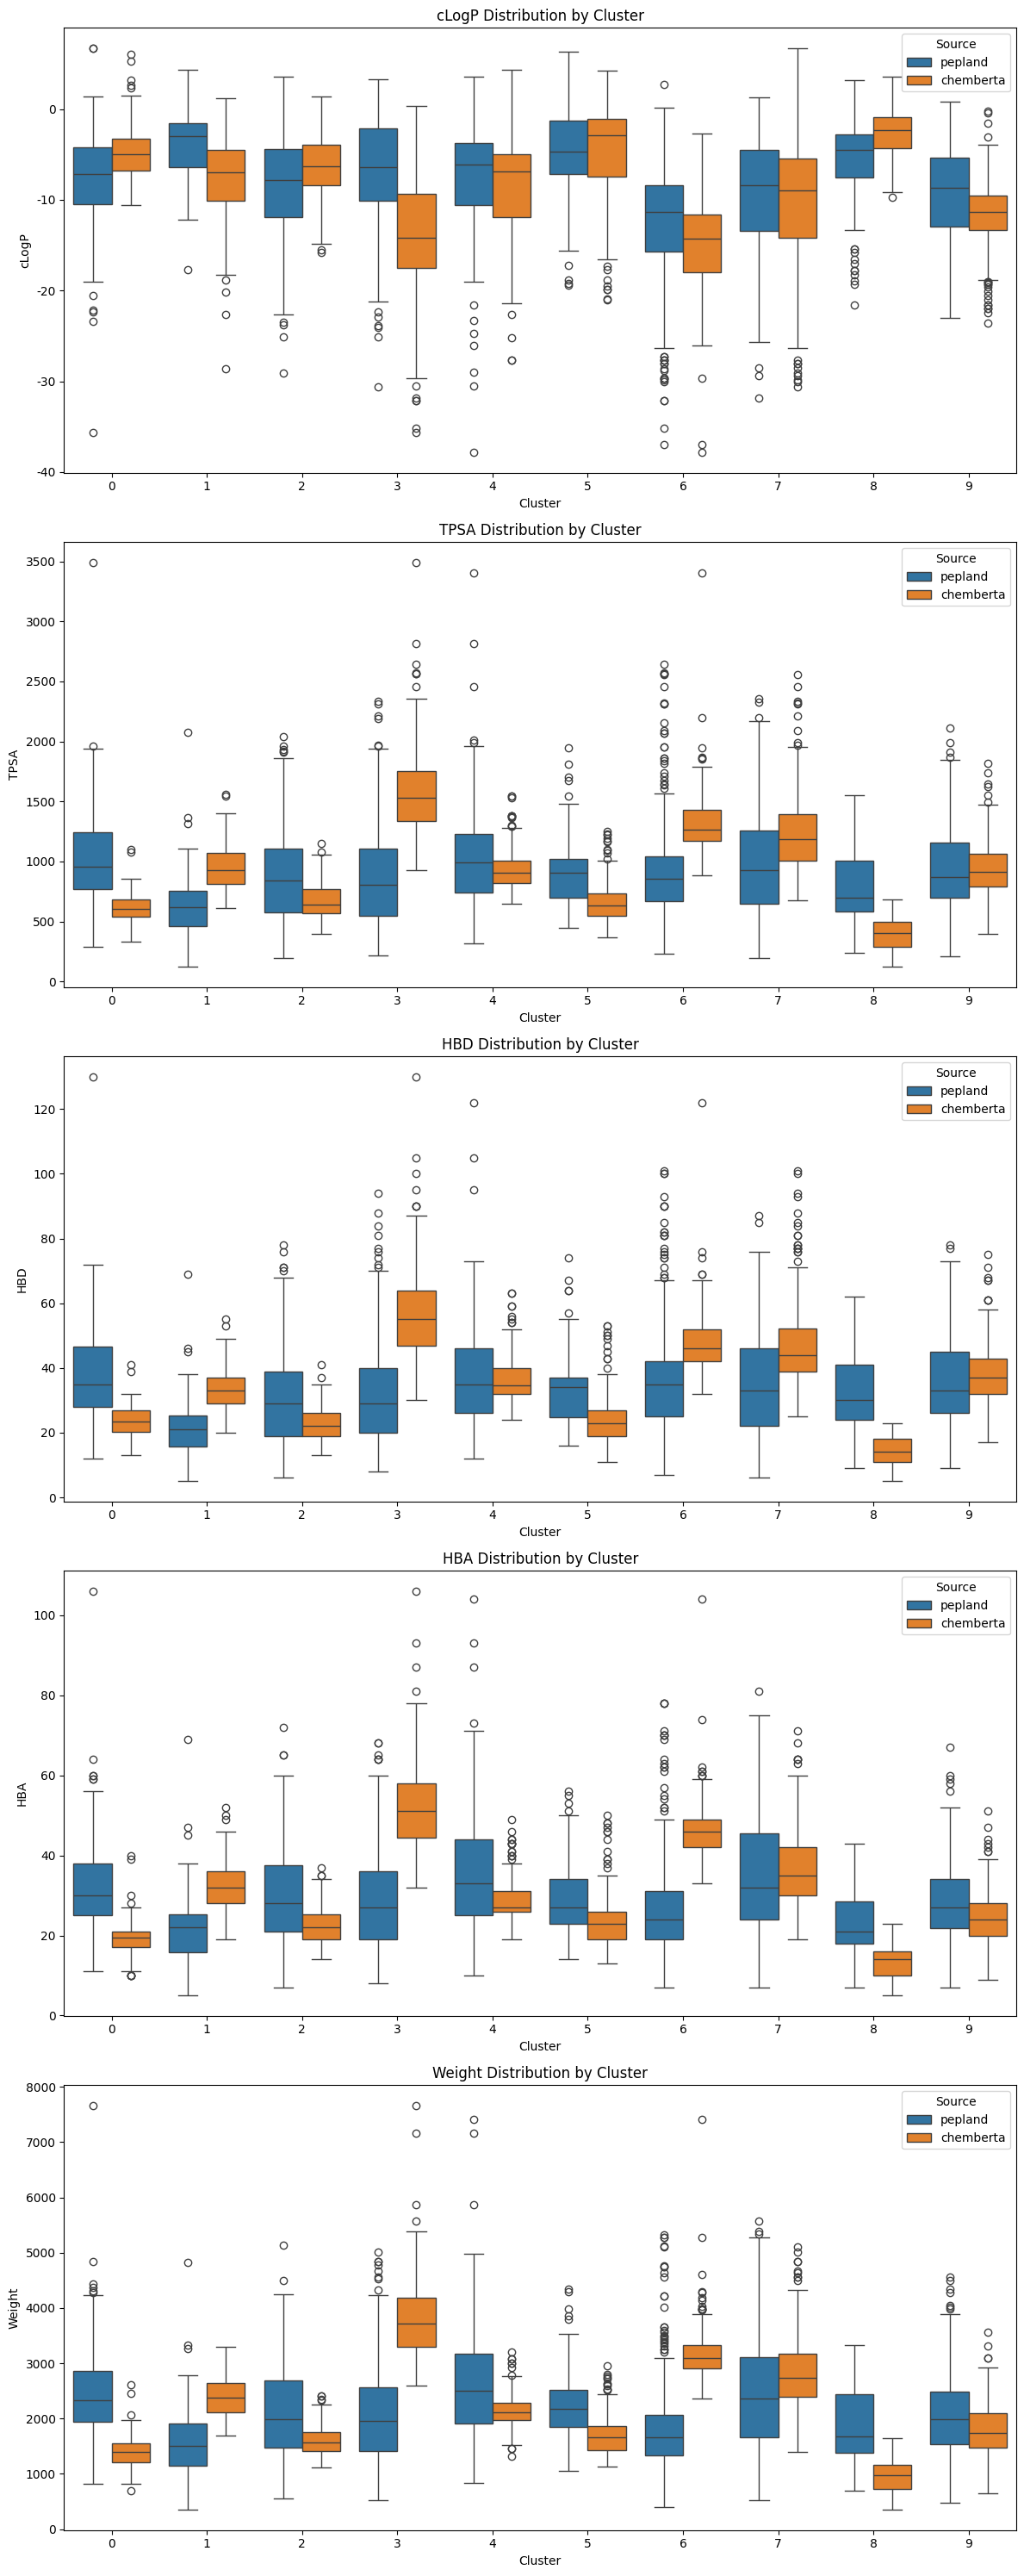

In [79]:
# use seaborn to draw boxplot for the distribution of the properties for each cluster
# compare the difference between pepland and chemberta

fig, axes = plt.subplots(len(properties), 1, figsize=(12, 6 * len(properties)))

# Add a 'Source' column to each DataFrame
pep_df_copy = pep_df.copy()
pep_df_copy['Source'] = 'pepland'

chemberta_df_copy = chemberta_df.copy()
chemberta_df_copy['Source'] = 'chemberta'

# Combine the DataFrames
combined_df = pd.concat([pep_df_copy, chemberta_df_copy], axis=0)

for idx, prop in enumerate(properties):
    sns.boxplot(
        x="Cluster",
        y=prop,
        hue="Source",
        data=combined_df,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{prop} Distribution by Cluster")
    axes[idx].legend(title='Source')
    
plt.tight_layout()
plt.show()
